In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from gym_power_trading.envs import PowerTradingEnv
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7



In [4]:
global _debug
_debug = False

In [26]:
file_name = 'data\AEP_PSGC1_AMP_long.h5'
path = Path(file_name).resolve()
uri = str(path)
df = pd.read_hdf(uri)
df.head()

HE
MARKET_DAY NODE          TYPE    VALUE HourEnding       
2021-07-01 AEP.PSGC1.AMP Gennode LMP   1           25.88
                                       2           24.88
                                       3           23.45
                                       4           22.47
                                       5           21.73

### Test Agent and Environment on this Sinusoidal time series data

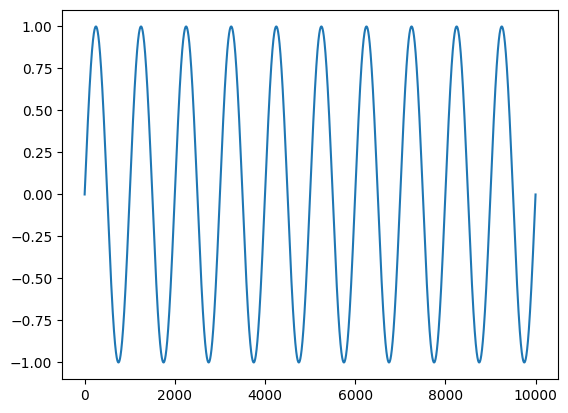

In [5]:
df = pd.read_csv("data\sinusoidal_data_10000_multi_period.csv")
plt.plot(df)

## Perform Random Actions in the Environment. Can Charge or Discharge battery or do nothing (Hold). 
- Agent earns reward for lowering its charge price and selling energy at a profit. 
- It's penalized for overcharging,  since this can reduce battery lifespan. 
- Power prices can go negative, in which case it's advantageous for the agent to charge since they're getting paid for the energy and disadvantageous to discharge since the agent is paying to distribute energy when it could be holding. 

In [6]:
env = PowerTradingEnv(df=df, window_size=3, frame_bound=(10, 100))
obs = env.reset()
for _ in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    print(info)
    if truncated:
        obs = env.reset()

100%|██████████| 100/100 [00:00<00:00, 19979.54it/s]

{'total_reward': 0.0048673923313617695, 'total_profit': -0.5026521533727646, 'position': <Actions.Charge: 1>, 'battery_charge': 20}
{'total_reward': 0.003453494459390638, 'total_profit': -1.1309301108121872, 'position': <Actions.Charge: 1>, 'battery_charge': 40}
{'total_reward': 0.003453494459390638, 'total_profit': -1.1309301108121872, 'position': <Actions.Hold: 2>, 'battery_charge': 40}
{'total_reward': 0.003453494459390638, 'total_profit': -1.1309301108121872, 'position': <Actions.Hold: 2>, 'battery_charge': 40}
{'total_reward': 0.003453494459390638, 'total_profit': -1.1309301108121872, 'position': <Actions.Hold: 2>, 'battery_charge': 40}
{'total_reward': 0.5339370919764042, 'total_profit': -0.006098931282758624, 'position': <Actions.Discharge: 0>, 'battery_charge': 20}
{'total_reward': 0.5211402980983257, 'total_profit': -1.2620348088443278, 'position': <Actions.Charge: 1>, 'battery_charge': 40}
{'total_reward': 0.5120733787119389, 'total_profit': -2.6433731965720653, 'position': <

In [8]:
check_env(env, warn=True)

## PPO Agent

In [20]:
venv = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=3, frame_bound=(10, 100)), n_envs=2)
model_100k = PPO('MlpPolicy', venv, device='cpu', verbose=True)

Using cpu device


### Plot of Agent Trades (Charge/Discharge) (100,000 Training Iterations)

-----------------------------
| time/              |      |
|    fps             | 3334 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1981        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013427058 |
|    clip_fraction        | 0.302       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00782     |
|    learning_rate        | 0.0003      |
|    loss                 | 52          |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0364     |
|    value_loss           | 117         |
-----------------------------------------
----------------------------------

[]

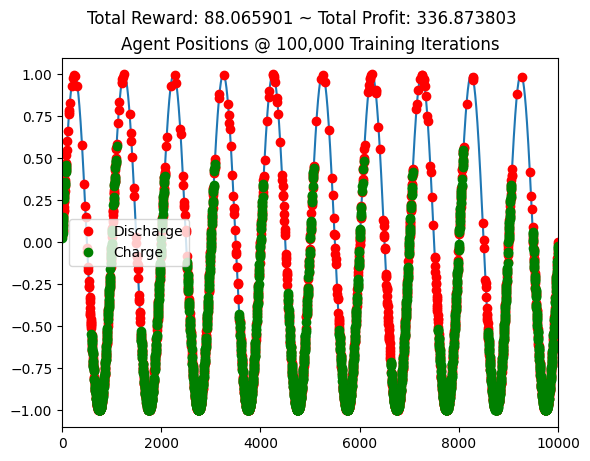

In [21]:
model_100k.learn(total_timesteps=100000)
env2 = PowerTradingEnv(df=df, window_size=3, frame_bound=(10, 100))
obs = env2.reset()
obs = obs[0]

for i in range(len(df)):
    action, states = model_100k.predict(obs)
    obs, rewards, term, trunc, info = env2.step(action)
    if term or trunc:
        history = env2.history
        pos = env2.render_all(title="Agent Positions @ 100,000 Training Iterations")
        env2.reset()

plt.plot()

### Plot of Agent Trades (Charge/Discharge) (10,000,000 Training Iterations)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 3260 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1975        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.015813738 |
|    clip_fraction        | 0.311       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.0138      |
|    learning_rate        | 0.0003      |
|    loss                 | 122         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0366     |
|    value_loss           | 178         |
-----------------------------------------
-----------------

[]

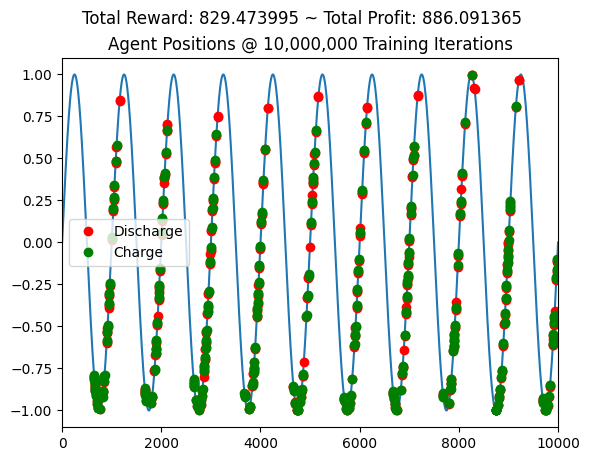

In [31]:
model_5MM = PPO('MlpPolicy', venv, verbose=1, device='cpu')
model_5MM.learn(total_timesteps=5000000)
env2 = PowerTradingEnv(df=df, window_size=3, frame_bound=(10, 100))
obs = env2.reset()
obs = obs[0]

for i in range(len(df)):
    action, states = model_5MM.predict(obs)
    obs, rewards, term, trunc, info = env2.step(action)
    if term or trunc:
        history = env2.history
        pos = env2.render_all(title="Agent Positions @ 10,000,000 Training Iterations")
        env2.reset()

plt.plot()

In [35]:
model_5MM.save("model_sinusoid_10MM")

#### Plot of Reward (PPO 100,000 Training Iterations)

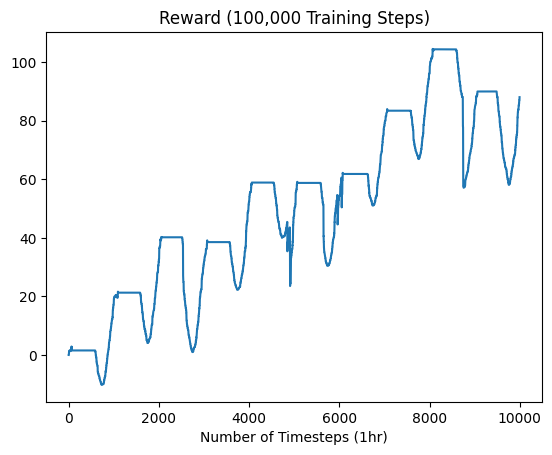

In [22]:
### PPO 10,000 Steps on Sinusoid
plt.plot(history['total_reward'])
plt.title("Reward (100,000 Training Steps)")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Plot of Reward (PPO 10,000,000 Training Iterations)

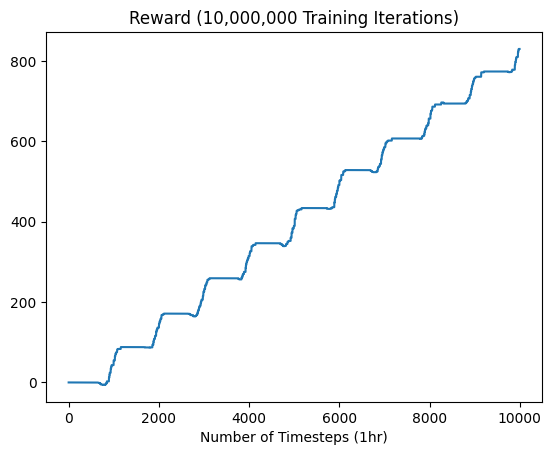

In [32]:
plt.plot(history['total_reward'])
plt.title("Reward (10,000,000 Training Iterations)")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Battery Charge (PPO 100,000 Training Iterations)

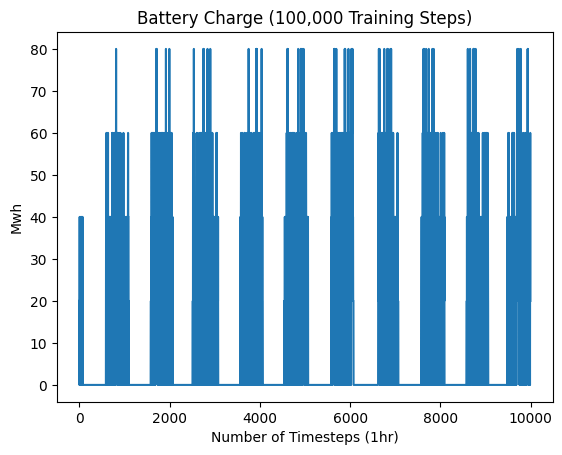

In [23]:
### PPO 10,000 Steps on Sinusoid
plt.plot(history['battery_charge'])
plt.title("Battery Charge (100,000 Training Steps)")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Battery Charge (PPO 10,000,000 Training Iterations)

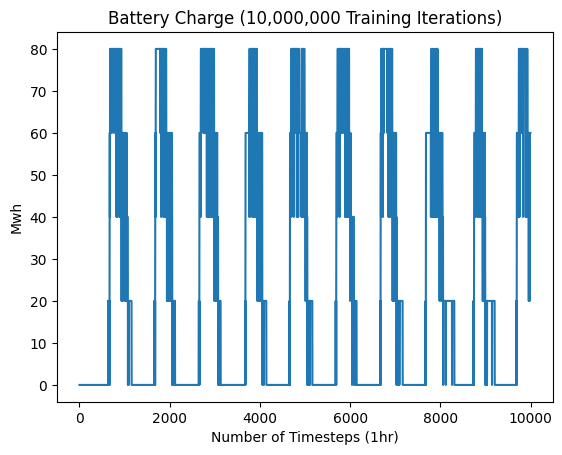

In [33]:
plt.plot(history['battery_charge'])
plt.title("Battery Charge (10,000,000 Training Iterations)")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Total Profit (PPO 100,000 Training Iterations)

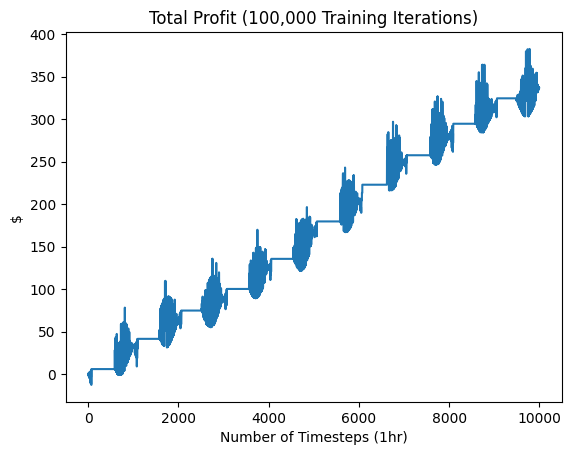

In [24]:
#### PPO 10,000 Steps on Sinusoid 
plt.plot(history['total_profit'])
plt.title("Total Profit (100,000 Training Iterations)")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Total Profit (PPO 10,000,000 Training Iterations)

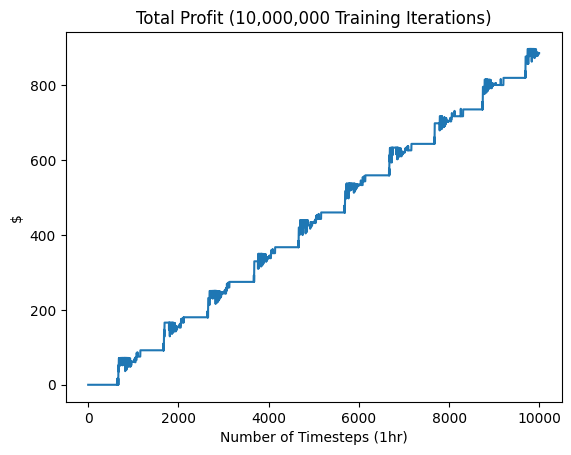

In [34]:
plt.plot(history['total_profit'])
plt.title("Total Profit (10,000,000 Training Iterations)")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()